# **LightFM 이용**

## **Import Modules**

In [ ]:
!pip install lightfm
!pip install scikit-optimize

In [ ]:
from google.colab import files
import os
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix

from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM
from skopt import forest_minimize

## **데이터 로드**

In [ ]:
file_path = "/content/drive/MyDrive/AIFFEL/해커톤3/모델 검증_토이데이터_211010"
book_path = file_path + '/goodreads_books_poetry.json.gz'
action_path = file_path + '/goodreads_interactions_poetry.json.gz'

book = pd.read_json(book_path, lines=True, compression='gzip')
action = pd.read_json(action_path, lines=True, compression='gzip')

In [ ]:
print(book.shape)
print(action.shape)

(36514, 29)
(2734350, 10)


In [ ]:
book.head()

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,similar_books,description,format,link,authors,publisher,num_pages,publication_day,isbn13,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,,1,[],US,eng,"[{'count': '8', 'name': 'to-read'}, {'count': ...",,false,3.83,,[],Number 30 in a series of literary pamphlets pu...,Paperback,https://www.goodreads.com/book/show/16037549-v...,"[{'author_id': '15585', 'role': ''}]","Houghton, Mifflin and Company",80,1,,11,,1887,https://www.goodreads.com/book/show/16037549-v...,https://images.gr-assets.com/books/1348176637m...,16037549,3,5212748,Vision of Sir Launfal and Other Poems,Vision of Sir Launfal and Other Poems
1,0811223981,2,[],US,,"[{'count': '100', 'name': 'to-read'}, {'count'...",,false,3.83,B00U2WY9U8,[],Fairy Tales gathers the unconventional verse d...,Paperback,https://www.goodreads.com/book/show/22466716-f...,"[{'author_id': '16073', 'role': ''}, {'author_...",New Directions,128,20,9780811223980,4,,2015,https://www.goodreads.com/book/show/22466716-f...,https://images.gr-assets.com/books/1404958407m...,22466716,37,41905435,Fairy Tales: Dramolettes,Fairy Tales: Dramolettes
2,0374428115,7,[],US,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,false,4.38,,[],Three poems describe the nighttime adventures ...,Paperback,https://www.goodreads.com/book/show/926662.Gro...,"[{'author_id': '18540', 'role': ''}, {'author_...",Farrar Straus Giroux,,12,9780374428112,7,,2008,https://www.goodreads.com/book/show/926662.Gro...,https://s.gr-assets.com/assets/nophoto/book/11...,926662,45,911665,Growltiger's Last Stand and Other Poems,Growltiger's Last Stand and Other Poems
3,0156182890,12,[],US,,"[{'count': '554', 'name': 'to-read'}, {'count'...",,false,3.71,B00IWTRB1W,"[1230072, 315167, 676169, 18522, 124335, 88263...",A modern verse play about the search for meani...,Paperback,https://www.goodreads.com/book/show/926667.The...,"[{'author_id': '18540', 'role': ''}]",Mariner Books,190,18,9780156182898,3,,1964,https://www.goodreads.com/book/show/926667.The...,https://images.gr-assets.com/books/1382939971m...,926667,115,995066,The Cocktail Party,The Cocktail Party
4,1942004192,4,[],US,eng,"[{'count': '228', 'name': 'to-read'}, {'count'...",,false,5.00,,"[25869488, 23630890, 25448131, 25464039, 42166...",Louder Than Everything You Love is about trans...,Paperback,https://www.goodreads.com/book/show/29065952-l...,"[{'author_id': '14308759', 'role': ''}]",ELJ Publications,118,23,9781942004196,12,First,2015,https://www.goodreads.com/book/show/29065952-l...,https://images.gr-assets.com/books/1455198396m...,29065952,9,49294781,Louder Than Everything You Love,Louder Than Everything You Love


In [ ]:
action.head()

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
0,8842281e1d1347389f2ab93d60773d4d,1384,1bad0122cebb4aa9213f9fe1aa281f66,True,4,,Wed May 09 09:33:44 -0700 2007,Wed May 09 09:33:44 -0700 2007,,
1,8842281e1d1347389f2ab93d60773d4d,1376,eb6e502d0c04d57b43a5a02c21b64ab4,True,4,,Wed May 09 09:33:18 -0700 2007,Wed May 09 09:33:18 -0700 2007,,
2,8842281e1d1347389f2ab93d60773d4d,30119,787564bef16cb1f43e0f641ab59d25b7,True,5,,Sat Jan 13 13:44:20 -0800 2007,Wed Mar 22 11:45:08 -0700 2017,Tue Mar 01 00:00:00 -0800 1983,
3,72fb0d0087d28c832f15776b0d936598,24769928,8c80ee74743d4b3b123dd1a2e0c0bcac,False,0,,Wed Apr 27 11:05:51 -0700 2016,Wed Apr 27 11:05:52 -0700 2016,,
4,72fb0d0087d28c832f15776b0d936598,30119,2a83589fb597309934ec9b1db5876aaf,True,3,,Mon Jun 04 18:58:08 -0700 2012,Mon Jun 04 18:58:13 -0700 2012,,


## **데이터 전처리**

##### - 사용하지 않을 column 제거

In [ ]:
book_data = book.drop(['series', 'is_ebook', 'kindle_asin', 'description', 'link', 'isbn13', 'url', 'title_without_series', 'edition_information', 'work_id', 'isbn', 'asin', 'popular_shelves', 'authors', 'publisher', 'publication_day', 'publication_month', 'country_code', 'similar_books', 'language_code', 'format'], axis=1)

In [ ]:
action[(action['is_read'] == False) & (action['rating'] != 0)]

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at


In [ ]:
action_data = action.drop(['review_id', 'is_read', 'review_text_incomplete', 'date_added', 'date_updated', 'read_at', 'started_at'], axis=1)

##### - missing value & 중복 처리

In [ ]:
book_data.dropna(inplace=True)
action_data.dropna(inplace=True)

In [ ]:
# book_data['language_code'].replace('', 'unknown', inplace=True)
# book_data['format'].replace('', 'no_format', inplace=True)
book_data['num_pages'].replace({'': -1, 0: -1}, inplace=True)
book_data['publication_year'].replace({'': 2100, 0: 2100}, inplace=True)

In [ ]:
book_data.drop_duplicates(inplace=True)
action_data.drop_duplicates(inplace=True)

In [ ]:
print(book_data.shape)
print(action_data.shape)

(36514, 8)
(2734350, 3)


##### - outlier 처리

In [ ]:
book_data['publication_year'] = pd.to_numeric(book_data['publication_year'])
book_data['publication_year'].describe()

count    36514.000000
mean      2016.818316
std        107.055295
min          0.000000
25%       2000.000000
50%       2009.000000
75%       2015.000000
max      20012.000000
Name: publication_year, dtype: float64

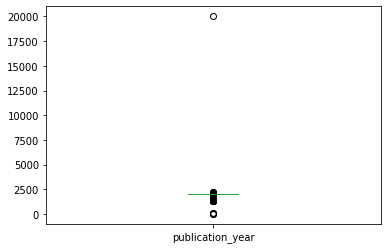

In [ ]:
book_data['publication_year'].plot.box()

In [ ]:
book_data[(book_data['publication_year'] > 2100) | (book_data['publication_year'] <= 1000)]

,text_reviews_count,average_rating,num_pages,publication_year,image_url,book_id,ratings_count,title
6047,1,3.91,128,2106,https://images.gr-assets.com/books/1503342601m...,36098998,11,Odes
6234,1,3.67,-1,0,https://s.gr-assets.com/assets/nophoto/book/11...,18808058,3,The Poems of Anyte of Tegea
9600,4,3.68,88,2204,https://images.gr-assets.com/books/1356399169m...,16052910,21,Ang Hayop na Ito!
17573,1,3.04,-1,148,https://images.gr-assets.com/books/1416505085m...,4936820,14,Laberinto de Fortuna
17667,2,4.30,105,0,https://s.gr-assets.com/assets/nophoto/book/11...,3235543,4,A Child's Garden of Verses
17784,1,4.39,2010,152,https://s.gr-assets.com/assets/nophoto/book/11...,11027605,23,Patria mea A4
18308,4,3.70,86,2204,https://images.gr-assets.com/books/1356399361m...,16052906,20,Estremelenggoles
21823,1,4.35,78,20012,https://images.gr-assets.com/books/1477226048m...,32729484,0,Orpheus’a Soneler


In [ ]:
book_data['publication_year'][21823] = 2012

book_data['publication_year'][6047, 9600, 18308] = 2100

In [ ]:
book_data.drop([17573, 17784], axis=0, inplace=True)

In [ ]:
book_data['publication_year'].describe()

count    36512.000000
mean      2016.421724
std         48.985190
min          0.000000
25%       2000.000000
50%       2009.000000
75%       2015.000000
max       2100.000000
Name: publication_year, dtype: float64

##### - categorical column 처리

In [ ]:
book_data['ratings_count'].describe()

count    3.651200e+04
mean     2.797025e+02
std      7.633623e+03
min      0.000000e+00
25%      9.000000e+00
50%      2.300000e+01
75%      6.900000e+01
max      1.029527e+06
Name: ratings_count, dtype: float64

In [ ]:
book_data['num_pages'] = pd.to_numeric(book_data['num_pages'])
book_data['num_pages'].describe()

count    36512.000000
mean       148.868509
std        208.713169
min         -1.000000
25%         33.750000
50%         96.000000
75%        188.000000
max      10960.000000
Name: num_pages, dtype: float64

In [ ]:
book_data = book_data.sort_values('book_id').reset_index(drop=True)

book_data.head()

,text_reviews_count,average_rating,num_pages,publication_year,image_url,book_id,ratings_count,title
0,24,4.17,-1,2100,https://s.gr-assets.com/assets/nophoto/book/11...,234,865,The Complete Verse and Other Nonsense
1,30,4.03,287,1940,https://s.gr-assets.com/assets/nophoto/book/11...,236,321,The Complete Nonsense of Edward Lear
2,51,3.35,32,2005,https://images.gr-assets.com/books/1328868141m...,241,155,A Was Once an Apple Pie
3,6,4.04,287,1996,https://images.gr-assets.com/books/1356458077m...,244,63,The Puffin Book Of Nonsense Verse
4,54,3.95,160,1962,https://s.gr-assets.com/assets/nophoto/book/11...,254,734,The Time of the Assassins: a Study of Rimbaud


In [ ]:
book_final = book_data.drop(['title', 'image_url'], axis=1).copy()

In [ ]:
# using pandas qcut method to convert fields into quantile-based discrete intervals
book_final['text_reviews_count'] = pd.qcut(book_final['text_reviews_count'], 20, duplicates='drop')
book_final['ratings_count'] = pd.qcut(book_final['ratings_count'], 25)
book_final['publication_year'] = pd.qcut(book_final['publication_year'], 20, duplicates='drop')
book_final['num_pages'] = pd.qcut(book_final['num_pages'], 20, precision=0, duplicates='drop')

# rounding ratings to neares .5 score
book_final['average_rating'] = book_final['average_rating'].apply(lambda x: round(x*2)/2)

In [ ]:
book_final.head()

,text_reviews_count,average_rating,num_pages,publication_year,book_id,ratings_count
0,"(23.0, 44.0]",4.0,"(-2.0, 34.0]","(2016.0, 2100.0]",234,"(614.0, 1029527.0]"
1,"(23.0, 44.0]",4.0,"(270.0, 343.0]","(-0.001, 1973.0]",236,"(285.0, 614.0]"
2,"(44.0, 10403.0]",3.5,"(-2.0, 34.0]","(2004.0, 2006.0]",241,"(125.0, 179.0]"
3,"(5.0, 6.0]",4.0,"(270.0, 343.0]","(1993.0, 1997.0]",244,"(59.0, 73.0]"
4,"(44.0, 10403.0]",4.0,"(160.0, 188.0]","(-0.001, 1973.0]",254,"(614.0, 1029527.0]"


In [ ]:
# dummify categorical features
book_final = pd.get_dummies(book_final, columns=['text_reviews_count', 'average_rating', 'num_pages', 'publication_year', 'ratings_count'])

In [ ]:
book_final.sample(5)

,book_id,"text_reviews_count_(-0.001, 1.0]","text_reviews_count_(1.0, 2.0]","text_reviews_count_(2.0, 3.0]","text_reviews_count_(3.0, 4.0]","text_reviews_count_(4.0, 5.0]","text_reviews_count_(5.0, 6.0]","text_reviews_count_(6.0, 7.0]","text_reviews_count_(7.0, 9.0]","text_reviews_count_(9.0, 11.0]","text_reviews_count_(11.0, 15.0]","text_reviews_count_(15.0, 23.0]","text_reviews_count_(23.0, 44.0]","text_reviews_count_(44.0, 10403.0]",average_rating_0.0,average_rating_1.0,average_rating_1.5,average_rating_2.0,average_rating_2.5,average_rating_3.0,average_rating_3.5,average_rating_4.0,average_rating_4.5,average_rating_5.0,"num_pages_(-2.0, 34.0]","num_pages_(34.0, 55.0]","num_pages_(55.0, 67.0]","num_pages_(67.0, 80.0]","num_pages_(80.0, 88.0]","num_pages_(88.0, 96.0]","num_pages_(96.0, 105.0]","num_pages_(105.0, 120.0]","num_pages_(120.0, 134.0]","num_pages_(134.0, 160.0]","num_pages_(160.0, 188.0]","num_pages_(188.0, 224.0]","num_pages_(224.0, 270.0]","num_pages_(270.0, 343.0]","num_pages_(343.0, 496.0]","num_pages_(496.0, 10960.0]",...,"publication_year_(1986.0, 1993.0]","publication_year_(1993.0, 1997.0]","publication_year_(1997.0, 2000.0]","publication_year_(2000.0, 2002.0]","publication_year_(2002.0, 2004.0]","publication_year_(2004.0, 2006.0]","publication_year_(2006.0, 2007.0]","publication_year_(2007.0, 2009.0]","publication_year_(2009.0, 2010.0]","publication_year_(2010.0, 2011.0]","publication_year_(2011.0, 2013.0]","publication_year_(2013.0, 2014.0]","publication_year_(2014.0, 2015.0]","publication_year_(2015.0, 2016.0]","publication_year_(2016.0, 2100.0]","ratings_count_(-0.001, 2.0]","ratings_count_(2.0, 3.0]","ratings_count_(3.0, 4.0]","ratings_count_(4.0, 5.0]","ratings_count_(5.0, 7.0]","ratings_count_(7.0, 8.0]","ratings_count_(8.0, 10.0]","ratings_count_(10.0, 12.0]","ratings_count_(12.0, 14.0]","ratings_count_(14.0, 16.0]","ratings_count_(16.0, 18.0]","ratings_count_(18.0, 21.0]","ratings_count_(21.0, 25.0]","ratings_count_(25.0, 29.0]","ratings_count_(29.0, 34.0]","ratings_count_(34.0, 40.0]","ratings_count_(40.0, 49.0]","ratings_count_(49.0, 59.0]","ratings_count_(59.0, 73.0]","ratings_count_(73.0, 94.0]","ratings_count_(94.0, 125.0]","ratings_count_(125.0, 179.0]","ratings_count_(179.0, 285.0]","ratings_count_(285.0, 614.0]","ratings_count_(614.0, 1029527.0]"
26798,17824924,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26238,17342451,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
25919,17186502,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26779,17800801,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9678,1281422,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
action_final = action_data.copy()

In [ ]:
action_final = action_final[action_final['rating'] != 0]

In [ ]:
print(book_final.shape)

print(action_data.shape)
print(action_final.shape)

(36512, 82)
(2734350, 3)
(1229059, 3)


## **CSR Matrix 생성**

##### - item dictionary 생성

In [ ]:
df = book_data[['book_id', 'title', 'image_url']]
df.reset_index(inplace=True)

In [ ]:
df

,index,book_id,title,image_url
0,0,234,The Complete Verse and Other Nonsense,https://s.gr-assets.com/assets/nophoto/book/11...
1,1,236,The Complete Nonsense of Edward Lear,https://s.gr-assets.com/assets/nophoto/book/11...
2,2,241,A Was Once an Apple Pie,https://images.gr-assets.com/books/1328868141m...
3,3,244,The Puffin Book Of Nonsense Verse,https://images.gr-assets.com/books/1356458077m...
4,4,254,The Time of the Assassins: a Study of Rimbaud,https://s.gr-assets.com/assets/nophoto/book/11...
...,...,...,...,...
36507,36507,36418610,Den vita rosen,https://images.gr-assets.com/books/1508097504m...
36508,36508,36441514,soft in the middle,https://s.gr-assets.com/assets/nophoto/book/11...
36509,36509,36443173,Semicolon ;,https://images.gr-assets.com/books/1509740993m...
36510,36510,36447192,"雪萊抒情詩選\t (經典文學寶庫, #6)",https://s.gr-assets.com/assets/nophoto/book/11...


In [ ]:
item_dict = {}

for i in range(df.shape[0]):
    item_dict[(df.loc[i,'book_id'])] = [df.loc[i,'title'], df.loc[i, 'image_url']]

In [ ]:
item_dict[36418610]

['Den vita rosen',
 'https://images.gr-assets.com/books/1508097504m/36418610.jpg']

##### - train, test 데이터셋 split -> csr matrix 생성

In [ ]:
book_csr = csr_matrix(book_final.drop('book_id', axis=1).values)
book_csr

<36512x81 sparse matrix of type '<class 'numpy.uint8'>'
	with 182560 stored elements in Compressed Sparse Row format>

In [ ]:
action_final.shape

(1229059, 3)

In [ ]:
action_sample = action_final.loc[action_final['user_id'].isin(random.sample(list(action_final['user_id'].unique()), k=10000))]

In [ ]:
action_sample.head()

,user_id,book_id,rating
88,8489357f2f485c1a961d4cbdc54ea84b,30119,3
90,8489357f2f485c1a961d4cbdc54ea84b,12914,3
92,8489357f2f485c1a961d4cbdc54ea84b,1381,5
93,8489357f2f485c1a961d4cbdc54ea84b,1519,4
94,8489357f2f485c1a961d4cbdc54ea84b,32552,4


In [ ]:
# interaction matrix
interaction = pd.pivot_table(action_sample, index='user_id', columns='book_id', values='rating')

# fill missing values with 0
interaction = interaction.fillna(0)

interaction.head()

book_id,234,236,254,284,286,289,290,291,292,459,462,676,1371,1372,1373,1374,1376,1378,1381,1382,1383,1384,1387,1388,1392,1405,1414,1416,1420,1432,1433,1434,1436,1463,1464,1465,1466,1467,1470,1483,...,34950035,35005413,35008689,35015965,35072625,35102806,35108792,35140962,35163722,35227520,35239438,35254618,35275314,35276110,35288488,35403000,35482106,35489040,35569315,35606560,35612306,35654589,35663570,35668923,35673978,35691576,35715114,35738258,35783117,35793528,35846198,35889367,35991559,36052409,36096745,36122873,36126998,36189499,36232007,36417323
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00130b2e4d35f9b0edee72c620d9a687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001aa4da5b2c1c53765b168224c7f106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00256a2c71f40fc50a7ae5fcff55a502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0026d40516cf87689bf9d009e3fe2609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002c3e87a952e89338cdf4a9e9b98a2d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_id = list(interaction.index)

user_dict = {}
counter = 0

for i in user_id:
  user_dict[i] = counter
  counter += 1

In [ ]:
# convert to csr matrix
interaction_csr = csr_matrix(interaction.values)
interaction_csr

<10000x9999 sparse matrix of type '<class 'numpy.float64'>'
	with 45082 stored elements in Compressed Sparse Row format>

In [ ]:
# train, test split
train_interaction_csr, test_interaction_csr = random_train_test_split(interaction_csr, test_percentage=0.2)

## **Model Train & Validate**

In [ ]:
model = LightFM(loss='warp',
                random_state=2021,
                learning_rate=0.90,
                no_components=150,
                user_alpha=0.000005)

model = model.fit(train_interaction_csr,
                  epochs=100,
                  num_threads=16, verbose=False)

In [ ]:
auc_train = auc_score(model, train_interaction_csr, num_threads=16).mean()
auc_test = auc_score(model, test_interaction_csr, num_threads=16).mean()

In [ ]:
print(auc_train)
print(auc_test)

0.6098849
0.5206513
